In [1]:
import utils_BudykoSellers
import utils_emulator
import numpy as np

%load_ext autoreload
%autoreload 2

## Experiment 2: Restricted Two Box (hidden variables)

This notebook runs the coupled three box model for the following scenarios and emulation techniques:

Scenarios:
1. Abrupt - An abrupt doubling of CO2 concentration; corresponds roughly to the *Abrupt2xCO2* CMIP experiment.
2. High Emissions - An exponential increase of CO2 concentration in time; corresponds roughly to *SSP585*.
3. Plateau - An increase in CO2 concentration in time that follows a hyperbolic tangent, increasing exponentially and then tapering off; corresponds roughly to *SSP245*.
4. Overshoot - An increase in CO2 concentration in time that follows a Gaussian profile, increasing and decreasingly rapidly; inspired by *SSP119*, but decreases more quickly.

Emulators:
1. Pattern Scaling - Time-invariant pattern based on linear regression from global mean temperature to local temperature.
2. Fluctuation Dissipation Theorem - Response functions derived through perturbation experiment.
3. Deconvolution - Response functions solved for from any general experiment.
4. Modal Fitting - Response functions fit from any general experiment.
5. Dynamic Mode Decomposition (DMD) - Approximating system dynamics with a linear operator.
6. Extended DMD - Approximating system dynamics with nonlinear basis functions.

Note: For this linear system, there is no increase in performance using EDMD with a higher-order basis. Both methods give identical results in this notebook.

### Setup and Run Scenarios

Required before creating/evaluating emulators.

In [2]:
# Required variables
t_end = 251
t = np.arange(0,t_end)
n_boxes = 1

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Plateau','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs[scen] = utils_BudykoSellers.Run_Budyko_Sellers(scen_flag=i,vert_diff_flag=1)
  forcings[scen] = full_outputs[scen]['forcing_ts'] # Don't tile the forcing like the other experiments
  T_out[scen] = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method I: Pattern Scaling

Train: Abrupt - NRMSE
	Test: Abrupt - [17.28879572]
	Test: High Emissions - [37.32393922]
	Test: Mid. Emissions - [20.22140428]
	Test: Overshoot - [26.2253667]
Train: High Emissions - NRMSE
	Test: Abrupt - [25.64458824]
	Test: High Emissions - [0.48744201]
	Test: Mid. Emissions - [16.42470557]
	Test: Overshoot - [24.00396845]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [20.45301356]
	Test: High Emissions - [15.79532599]
	Test: Mid. Emissions - [10.39364788]
	Test: Overshoot - [19.80446701]
Train: Overshoot - NRMSE
	Test: Abrupt - [20.27224098]
	Test: High Emissions - [16.46928868]
	Test: Mid. Emissions - [10.40783051]
	Test: Overshoot - [19.79666015]


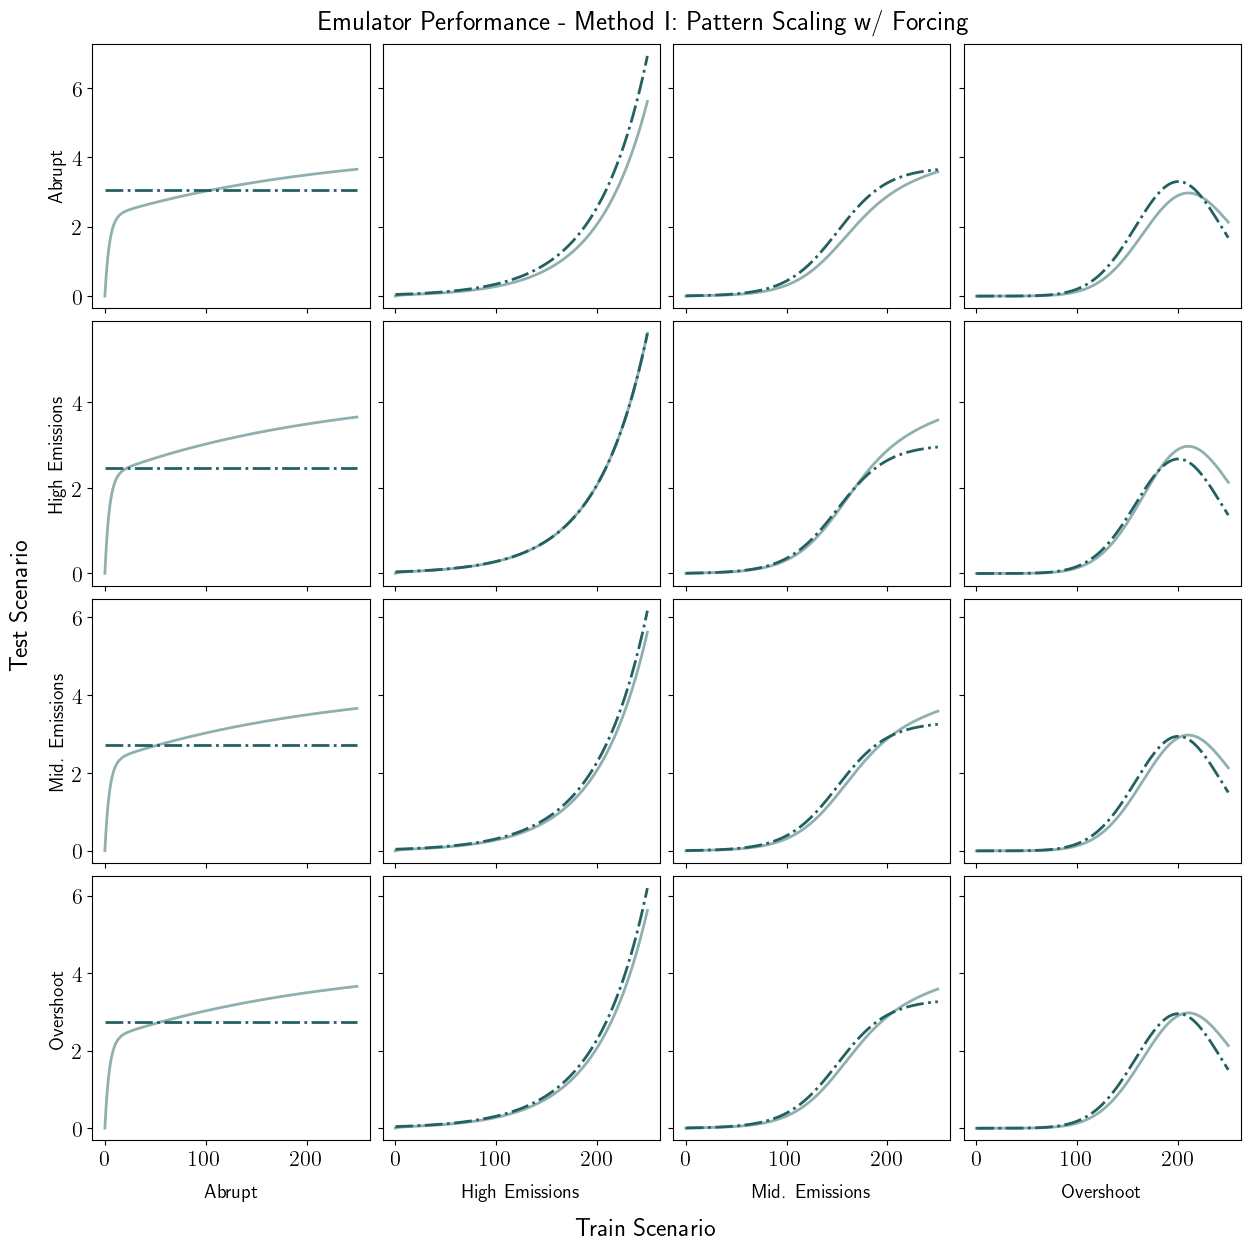

In [3]:
verbose    = True   # Show error output
plot       = True   # Plot emulator performance
save_error = False  # Save error output

operator_PS, T_pred_PS, error_metrics_PS = utils_emulator.emulate_scenarios('PS_forcing', scenarios=scenarios, outputs=T_out, forcings=forcings, verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_PS, scenarios, operator='PS_forcing')

if save_error:
  utils_emulator.save_results(error_metrics_PS, 'exp2_I_PS_error')

### Method II: Fluctuation Dissipation Theorem

Train: Impulse Forcing - NRMSE
	Test: Abrupt - [0.60544245]
	Test: High Emissions - [0.68742602]
	Test: Mid. Emissions - [0.53949338]
	Test: Overshoot - [1.14741805]


/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


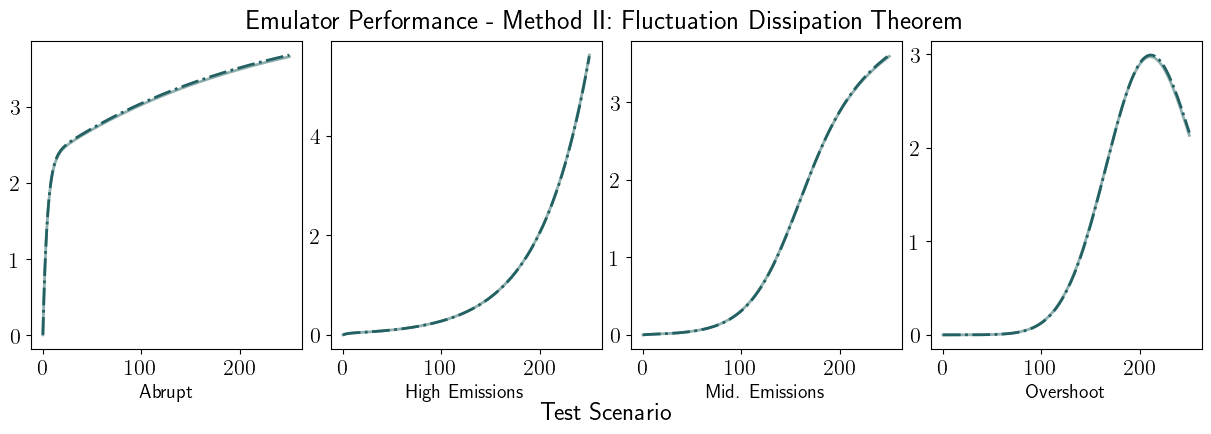

In [4]:
verbose    = True    # Show error output
plot       = True    # Plot emulator performance
save_error = False   # Save error output

dt = 1 # Timestep (year)
operator_FDT, T_pred_FDT, error_metrics_FDT = utils_emulator.emulate_scenarios('FDT', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, vert_diff_flag=1, delta=1, verbose=verbose)

if plot:
  utils_emulator.plot_true_pred_FDT(T_out, T_pred_FDT, scenarios)

if save_error:
  utils_emulator.save_results(error_metrics_FDT, 'exp2_II_FDT_error')

### Method III: Deconvolution

Train: Abrupt - NRMSE


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


	Test: Abrupt - [0.02867493]
	Test: High Emissions - [1.64189674]
	Test: Mid. Emissions - [0.72562174]
	Test: Overshoot - [1.00287927]
Train: High Emissions - NRMSE
	Test: Abrupt - [1.08136686]
	Test: High Emissions - [0.01014362]
	Test: Mid. Emissions - [1.02434571]
	Test: Overshoot - [1.60856793]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [6.62019457]
	Test: High Emissions - [1.11199795]
	Test: Mid. Emissions - [0.1612503]
	Test: Overshoot - [0.51942227]
Train: Overshoot - NRMSE
	Test: Abrupt - [8.32446082]
	Test: High Emissions - [1.4306001]
	Test: Mid. Emissions - [0.42587692]
	Test: Overshoot - [0.20680614]


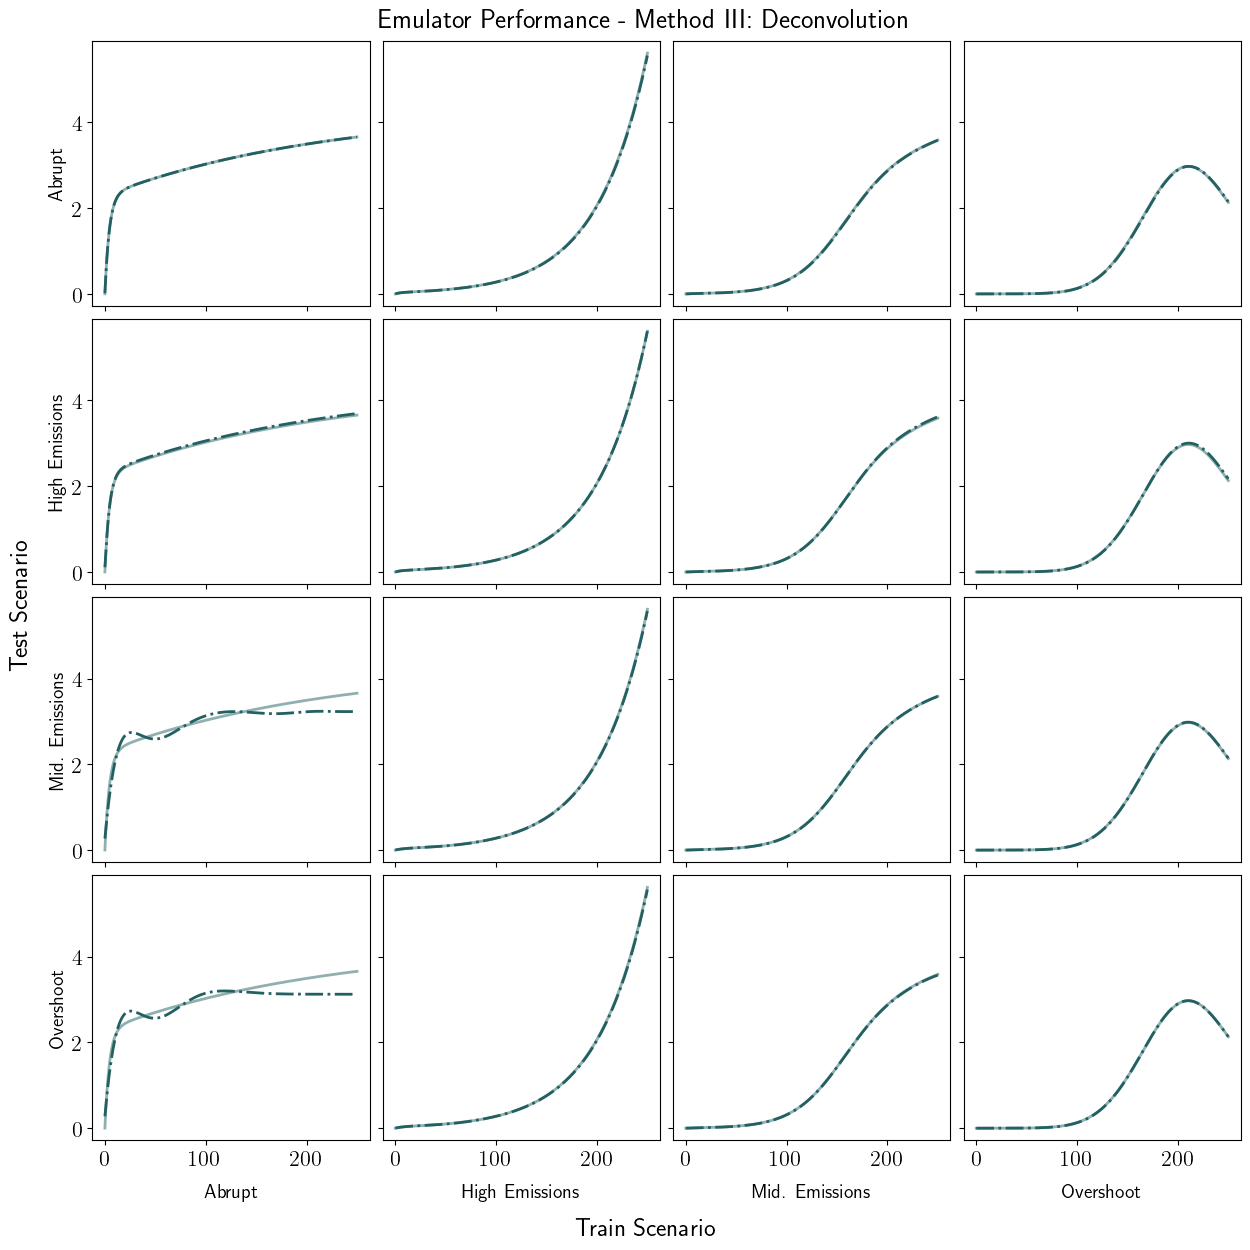

In [5]:
verbose    = True   # Show error output
plot       = True   # Plot emulator performance
save_error = False  # Save error output

dt = 1 # Timestep (year)
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = utils_emulator.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt, regularize=True,verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_deconvolve, scenarios, operator='deconvolve')

if save_error:
  utils_emulator.save_results(error_metrics_deconvolve, 'exp2_III_deconv_error')

### Method IV: Modal Fitting

Train: Abrupt - NRMSE
[ 6.0109324 -1.8537142 -5.3871145 -1.4885014]
	Test: Abrupt - [0.46142286]
	Test: High Emissions - [2.08449808]
	Test: Mid. Emissions - [1.08352027]
	Test: Overshoot - [1.12648151]
Train: High Emissions - NRMSE
[ 4.0116763 -4.811978  -4.2202263 -3.4490767]
	Test: Abrupt - [45.62450399]
	Test: High Emissions - [1.08998168]
	Test: Mid. Emissions - [34.52850443]
	Test: Overshoot - [51.2140961]
Train: Mid. Emissions - NRMSE
[ 4.693689  -2.7269857 -2.1446002 -2.4493465]
	Test: Abrupt - [12.45112681]
	Test: High Emissions - [5.72085272]
	Test: Mid. Emissions - [2.20997134]
	Test: Overshoot - [4.92252272]
Train: Overshoot - NRMSE
[ 3.5522068 -2.6911218 -1.2357907 -2.3629017]
	Test: Abrupt - [14.41045894]
	Test: High Emissions - [7.11510075]
	Test: Mid. Emissions - [4.6193798]
	Test: Overshoot - [2.90483559]


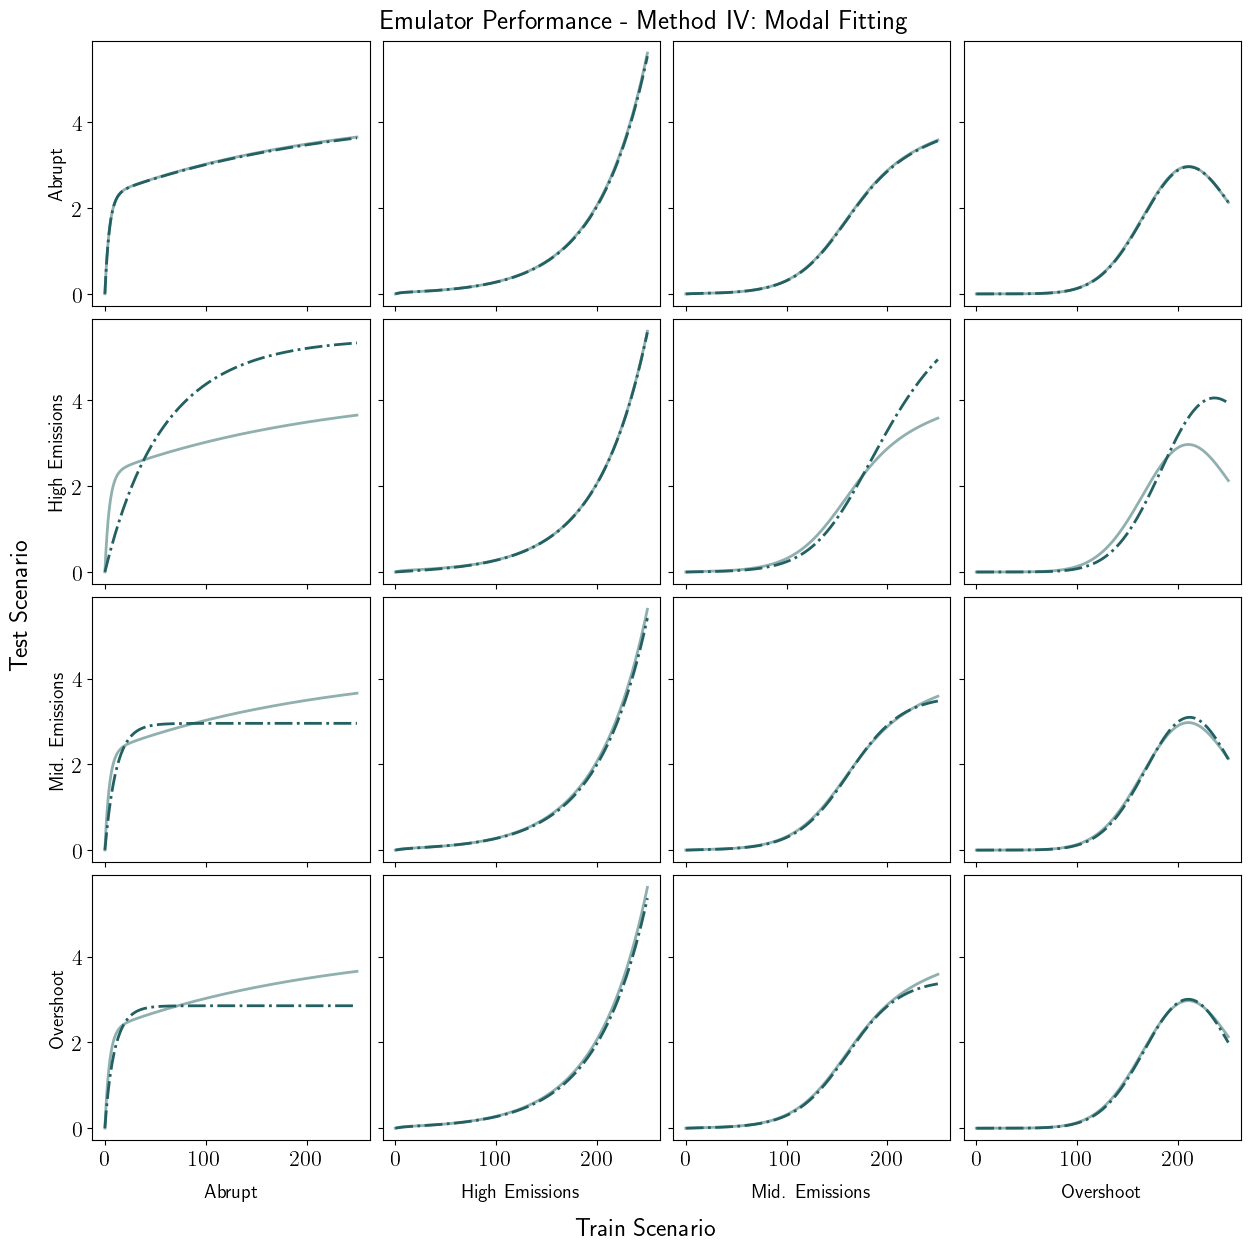

In [6]:
verbose    = True   # Show error output and optimal parameters
plot       = True   # Plot emulator performance
save_error = False  # Save error output

dt = 1 # Timestep (year)
operator_fit, T_pred_fit, error_metrics_fit = utils_emulator.emulate_scenarios('modal', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=2, B=np.ones(n_boxes), verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_fit, scenarios, operator='modal')

if save_error:
  utils_emulator.save_results(error_metrics_fit, 'exp2_IV_modal_error')

### Method V: Dynamic Mode Decomposition (DMD)

Train: Abrupt - NRMSE
	Test: Abrupt - [9.63265206]
	Test: High Emissions - [3.14680562]
	Test: Mid. Emissions - [10.98462538]
	Test: Overshoot - [17.45344218]
Train: High Emissions - NRMSE
	Test: Abrupt - [13.33742725]
	Test: High Emissions - [0.25784346]
	Test: Mid. Emissions - [3.32799202]
	Test: Overshoot - [5.27988008]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [11.52922246]
	Test: High Emissions - [6.36385085]
	Test: Mid. Emissions - [2.38457171]
	Test: Overshoot - [7.23203003]
Train: Overshoot - NRMSE
	Test: Abrupt - [13.86235625]
	Test: High Emissions - [7.85235934]
	Test: Mid. Emissions - [3.99766457]
	Test: Overshoot - [3.28354709]


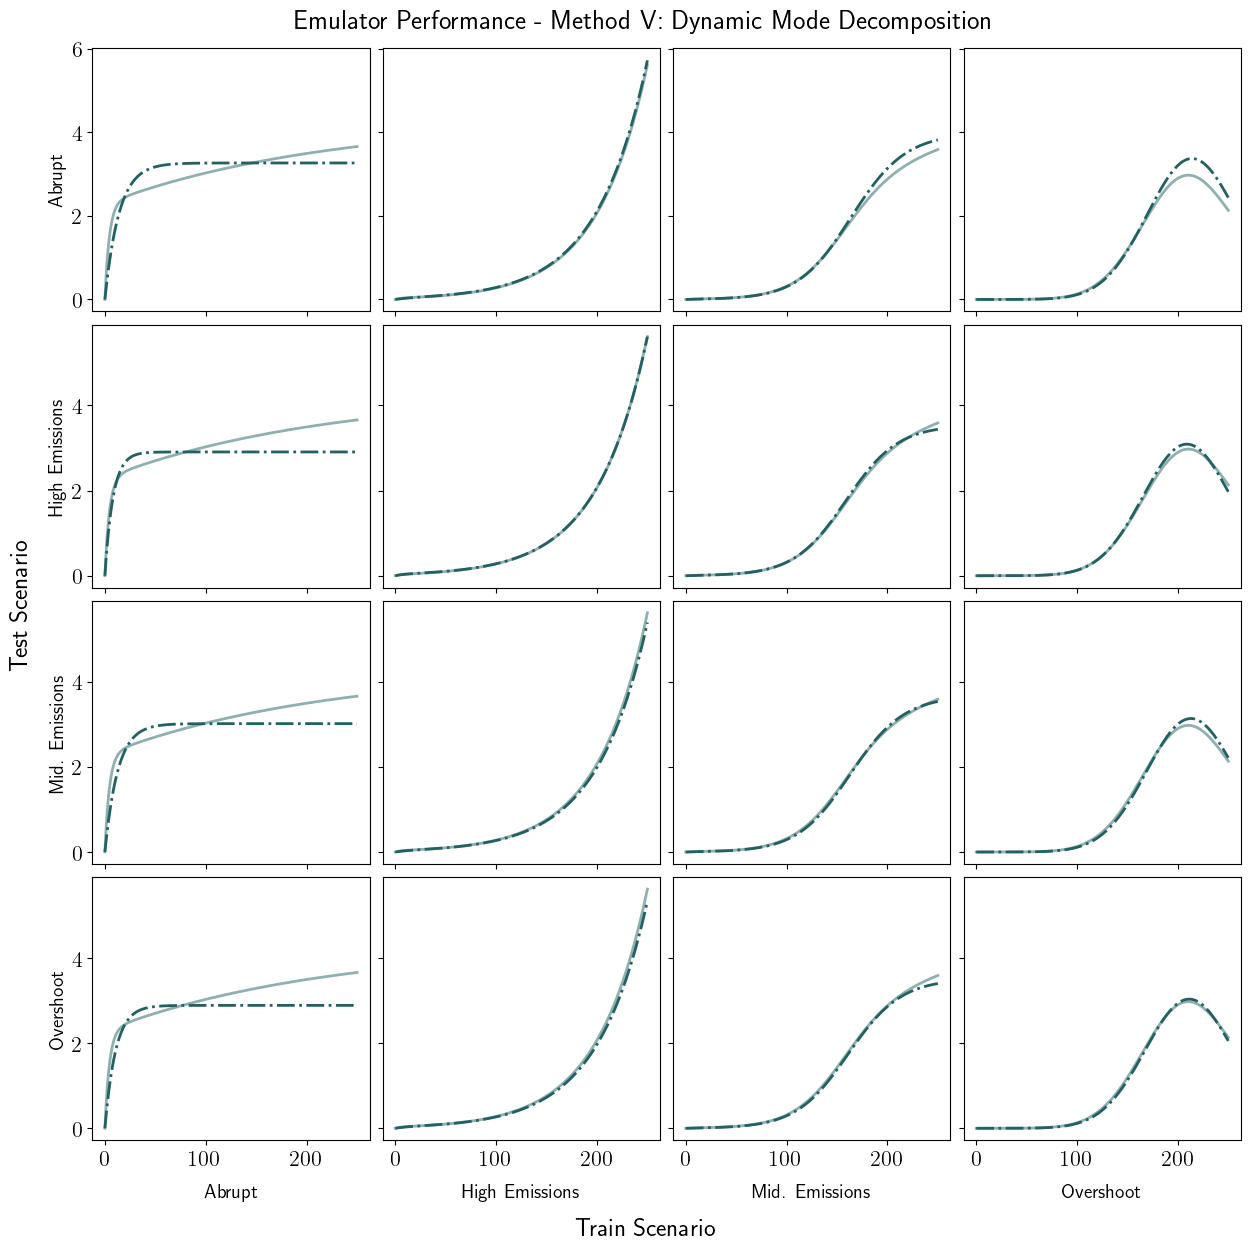

In [7]:
verbose    = True   # Show error output
plot       = True   # Plot emulator performance
save_error = False  # Save error output

n_steps = len(t)            # No. timesteps
w0      = np.zeros(n_boxes) # Initial condition
operator_DMD, T_pred_DMD, error_metrics_DMD = utils_emulator.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, n_steps=n_steps, n_boxes=n_boxes, regularize=True)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_DMD, scenarios, operator='DMD')

if save_error:
  utils_emulator.save_results(error_metrics_DMD, 'exp2_V_DMD_error')

### Method VI: Extended DMD

Train: Abrupt - NRMSE
	Test: Abrupt - [9.63265846]
	Test: High Emissions - [3.14728122]
	Test: Mid. Emissions - [10.98473642]
	Test: Overshoot - [17.45339282]
Train: High Emissions - NRMSE
	Test: Abrupt - [14.09141036]
	Test: High Emissions - [0.25802587]
	Test: Mid. Emissions - [3.80968737]
	Test: Overshoot - [5.40886545]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [11.53021672]
	Test: High Emissions - [6.35926076]
	Test: Mid. Emissions - [2.38344237]
	Test: Overshoot - [7.22842801]
Train: Overshoot - NRMSE
	Test: Abrupt - [13.86256615]
	Test: High Emissions - [7.85069572]
	Test: Mid. Emissions - [3.99741478]
	Test: Overshoot - [3.28285628]


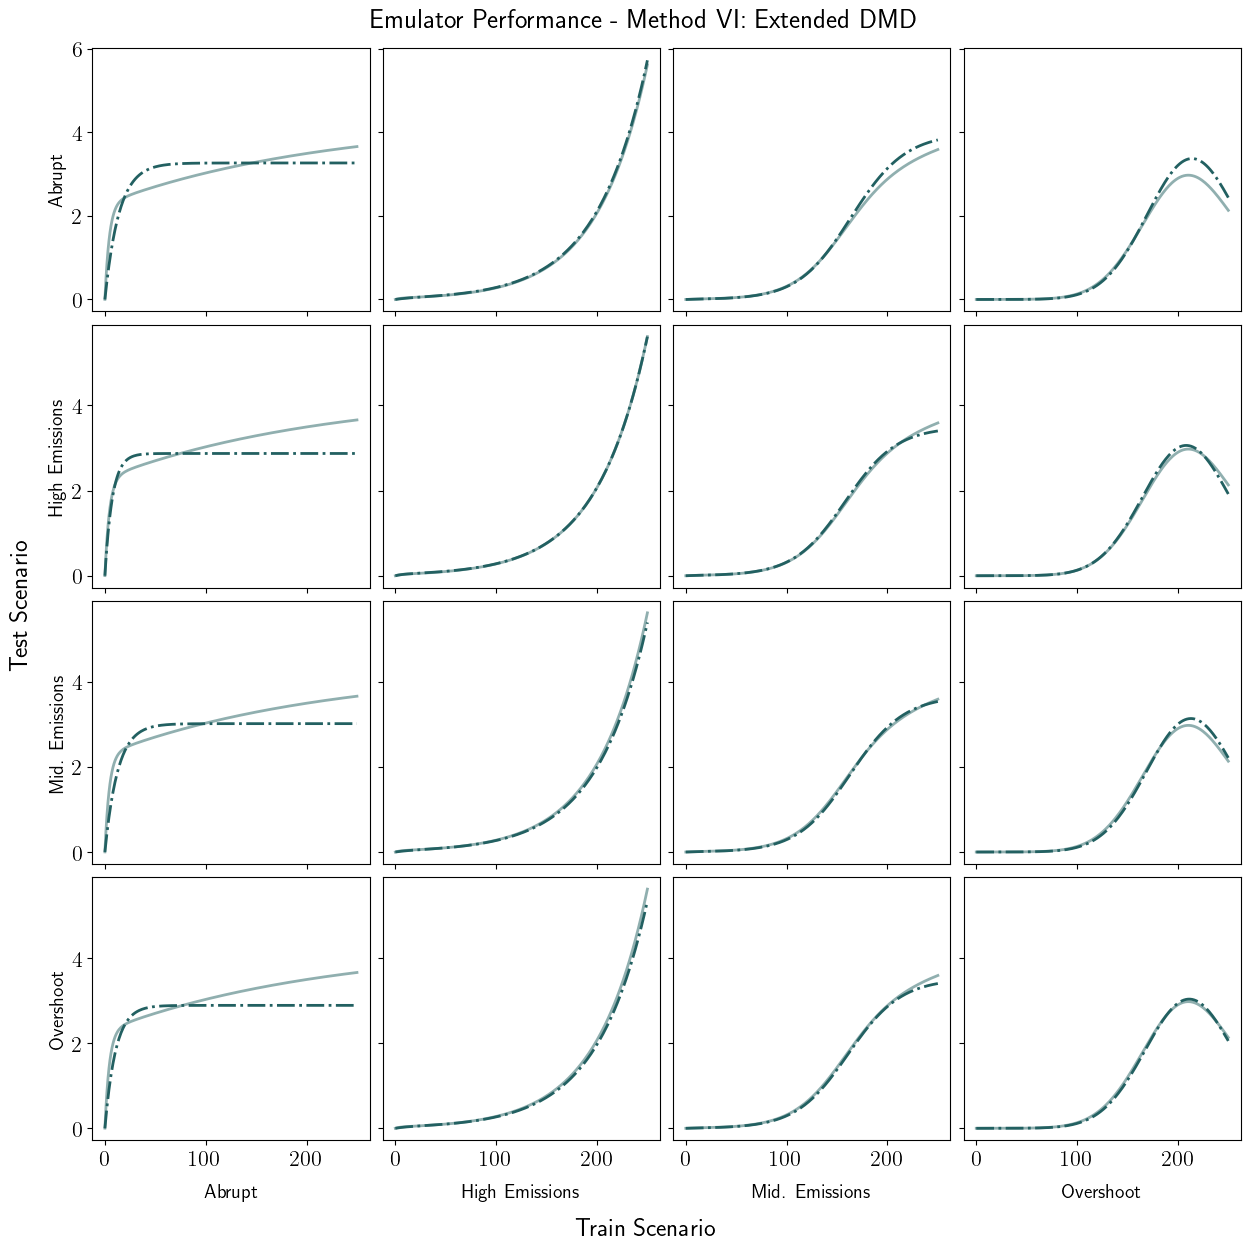

In [8]:
verbose    = True   # Show error output and optimal parameters
plot       = True   # Plot emulator performance
save_error = False  # Save error output

n_steps = len(t)            # No. timesteps
w0      = np.zeros(n_boxes) # Initial condition

# Basis functions
w_dict = utils_emulator.Vector_Dict(method='hermite', degree=1)
F_dict = utils_emulator.Vector_Dict(method='hermite', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = utils_emulator.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict, regularize=True)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_EDMD, scenarios, operator='EDMD')

if save_error:
  utils_emulator.save_results(error_metrics_EDMD, 'exp2_VI_EDMD_error')